In [16]:
from openqaoa import QAOA, create_device
import networkx as nx
import matplotlib.pyplot as plt
from openqaoa.problems import MinimumVertexCover, MaximumCut
from openqaoa.utilities import plot_graph
from qiskit import IBMQ
import qiskit
from qiskit import qasm3
import numpy as np
from pprint import pprint

IBMQ.save_account(
    "1b0ab941b010112fea6054ef44befc6d05ea3eca559a8b7b9dcaf68adcac0a64b6f24eafce9f69b96e6bf67eb223e27c7085ab8da9e12a0ba54f10c48616effa"
)

In [3]:
g = nx.generators.fast_gnp_random_graph(n=6, p=0.6, seed=42)

#graphProblem = MinimumVertexCover(g, field=1.0, penalty=30)
graphProblem = MaximumCut(g)
qubo_problem = graphProblem.qubo

/Users/kv18799/Github/QAOAstudygit/openQAOAvenv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


Ground State energy: -6.0, Solution: ['001110', '110001']


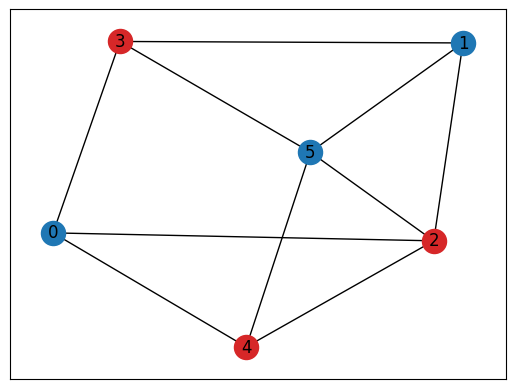

In [4]:
#Optional block, this is finding the exact solutions to the problem, useful for checking if the QAOA is configured well
hamiltonian = qubo_problem.hamiltonian
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")
#plot the solution on graph
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels={node: node for node in g.nodes()});

In [5]:
#Local simulation block
# Create the QAOA
q = QAOA()

# Load account from disk
IBMQ.load_account()
# Create a device
local_CPU = create_device(location="local", name="qiskit.qasm_simulator")
q.set_device(local_CPU)


# circuit properties. This method allows to shape the properties of the ansats circuit.
# It is the place where you can select the number of layers p, the type desired parametrization (and its initialization),
# and the type of mixer that you want to use.
q.set_circuit_properties(
    p=3, param_type="standard", init_type="ramp", mixer_hamiltonian="xy"
)

# backend properties. here we are fixing: - The number of shots: this is a fundamental value when running computations on a QPU or on a shot-based simulator -
# The initial round of Hamiltonians is set to True -
# Setting the value for the Conditional Value-at-Risk, a trick employed during the calculation of the expectation value
q.set_backend_properties(init_hadamard=True, n_shots=8000, cvar_alpha=0.85)

# classical optimizer properties. Note that since we are running the computation over the cloud we set maxiter=200 (that is, we cap the number of circuit evaluations to 200)
# and set a tolerance tol=0.05, roughly meaning that we will stop the optimization loop as soon as gains between consecutive cost values are smaller than the tolerance.
# Currently OpenQAOA allows both for gradient based and gradient free optimization methods, together with a wide selections of optimizers inherited both by SciPy and PennyLane.
q.set_classical_optimizer(method="cobyla", maxiter=200, tol=0.01)

In [6]:
q.compile(qubo_problem)

In [7]:
q.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

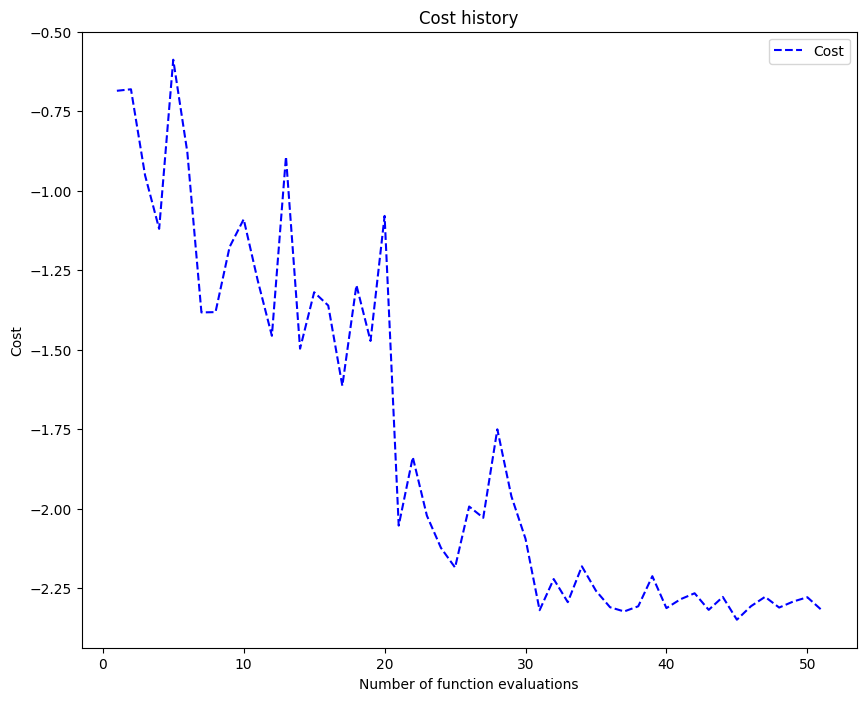

In [8]:
q.result.plot_cost()

In [12]:
results = q.result.optimized
binaryStrings = results['measurement_outcomes']
sortedBS = sorted(binaryStrings.items(), key=lambda item: item[1], reverse=True)
print(sortedBS[:8])
pprint(results) #uncomment for all results

[('110001', 666), ('110000', 656), ('001110', 625), ('001111', 617), ('011110', 293), ('100001', 280), ('001100', 259), ('101001', 255)]
{'angles': [0.902179802986,
            1.159986234988,
            0.537223591798,
            0.206794184595,
            0.013976101645,
            1.18709022798],
 'cost': -2.34975,
 'eval_number': 45,
 'job_id': '843ca164-170c-4063-a5f0-20913f82cb95',
 'measurement_outcomes': {'000000': 145,
                          '000001': 164,
                          '000010': 168,
                          '000011': 20,
                          '000100': 154,
                          '000101': 107,
                          '000110': 115,
                          '000111': 104,
                          '001000': 23,
                          '001001': 107,
                          '001010': 53,
                          '001011': 8,
                          '001100': 259,
                          '001101': 152,
                          '001110': 

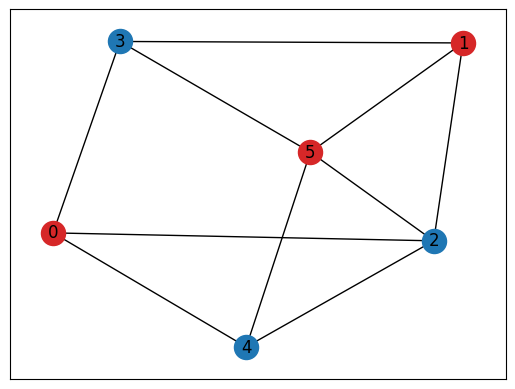

In [10]:
bestSolution = sortedBS[:1][0][0]
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(bestSolution) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(bestSolution) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels={node: node for node in g.nodes()});

In [18]:
variational_params = q.optimizer.variational_params
#create the optimized QAOA circuit for qiskit backend
optimized_angles = results['angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)
print(variational_params)

parameterized_circuit = q.backend.parametric_circuit 
OUTPUT_QASM_FILE = 'openQAOASimCircuit.qasm3'
print(f"Exporting circuit to {OUTPUT_QASM_FILE}...")
# Use qiskit.qasm3 exporter available in the environment
qasm3_string = qiskit.qasm3.dumps(optimized_circuit)
with open(OUTPUT_QASM_FILE, 'w') as f:
    f.write(qasm3_string)
print("Circuit export successful.")

#print the optimized QAOA circuit for qiskit backend
#optimized_circuit.draw()

Standard Parameterisation:
	p: 3
Variational Parameters:
	betas: [0.9021798  1.15998623 0.53722359]
	gammas: [0.20679418 0.0139761  1.18709023]

Exporting circuit to openQAOASimCircuit.qasm3...
Circuit export successful.
